# Import librarys

In [2]:
%load_ext dotenv
%dotenv

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from gensim.models import KeyedVectors # word2vec

rs = np.random.RandomState(4) # reprodutivibilidade

# Dataset
For this project, we will use data from an [open source dataset][1]
made by [Elo7][2], the largest online handcrafts marketplace in Brazil.
It contains data based on Elo7's search engine usage.

For the first part of this project, sample data is available in a
[CSV][3] file named `sample_producs.csv`. It contains a **header**
and **38k rows**.

The fields composing each row are specified in the table below:

| **Field**           | **Description**                                                                              |
| ------------------- | -------------------------------------------------------------------------------------------- |
| `product_id`        | Product numeric identification                                                               |
| `seller_id`         | Seller numeric identification                                                                |
| `query`             | The text inserted by users                                                                   |
| `search_page`       | The page number the product appeared (min 1 and max 5)                                       |
| `position`          | The position the product appeared in the search page (min 0 and max 38)                      |
| `title`             | Product title                                                                                |
| `concatenated_tags` | Product tags inserted by the seller                                                          |
| `creation_date`     | The date of product registration in Elo7 platform                                            |
| `price`             | The product price (R$)                                                                       |
| `weight`            | The weight (grams) of a product unit                                                         |
| `express_delivery`  | Indicates if the product has already been made (1) or not (0)                                |
| `minimum_quantity`  | The minimum quantity the seller sells the product                                            |
| `view_counts`       | The number of times the product was clicked in the last three months                         |
| `order_counts`      | The number of times the product was purchased in the last three months                       |
| `category`          | Product category                                                                             |

[1]: https://github.com/elo7/data7_oss/tree/master/elo7-search
[2]: https://elo7.com.br/sobre


In [3]:
# Load dataset
dataset_path = os.environ['DATASET_PATH']
df = pd.read_csv(dataset_path, index_col=0)

# Fix types
df['query'] = df['query'].astype('string')
df['title'] = df['title'].astype('string')
df['concatenated_tags'] = df['concatenated_tags'].astype('string')
df['creation_date'] = pd.to_datetime(df['creation_date'])
df['order_counts'][df['order_counts'].isnull()] = 0
df['category'] = df['category'].astype('category')

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38000 entries, 11394449 to 6866725
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   seller_id          38000 non-null  int64         
 1   query              38000 non-null  string        
 2   search_page        38000 non-null  int64         
 3   position           38000 non-null  int64         
 4   title              38000 non-null  string        
 5   concatenated_tags  37998 non-null  string        
 6   creation_date      38000 non-null  datetime64[ns]
 7   price              38000 non-null  float64       
 8   weight             37942 non-null  float64       
 9   express_delivery   38000 non-null  int64         
 10  minimum_quantity   38000 non-null  int64         
 11  view_counts        38000 non-null  int64         
 12  order_counts       38000 non-null  float64       
 13  category           38000 non-null  category      
dt

In [4]:
df['category'].value_counts()

Lembrancinhas         17524
Decoração              8723
Bebê                   6930
Papel e Cia            2750
Outros                 1133
Bijuterias e Jóias      940
Name: category, dtype: int64

In [5]:
len(df['query'].unique())

6377

In [6]:
df.head(5)

,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
product_id,,,,,,,,,,,,,,
11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,0.0,Decoração
15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5,124,0.0,Papel e Cia
16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,0.0,Outros
15877252,8071206,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,1,1,180,1.0,Bebê
15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,0.0,Decoração


## Hipoteses
- A categoria está altamente relacionada com as tags e titulos, mas dificil de extrair
- Alguma a correlação do target para peso, preço e quantidade minima
- Order count e express_delivery provavelmente não dizendo nada
- Os mais clicados numa mesma query estão mais relacionados com o tema (dificil confirmar)
- Mesmos vendendores venderem a msm categoria

### Há forte correlação entre peso, preço, quantidade minima e categoria?

In [25]:
onehot = pd.get_dummies(df['category'], prefix='Category')
df_correct = df[['price', 'weight', 'minimum_quantity']].join(onehot)
df_correct.dtypes

price                          float64
weight                         float64
minimum_quantity                 int64
Category_Bebê                    uint8
Category_Bijuterias e Jóias      uint8
Category_Decoração               uint8
Category_Lembrancinhas           uint8
Category_Outros                  uint8
Category_Papel e Cia             uint8
dtype: object

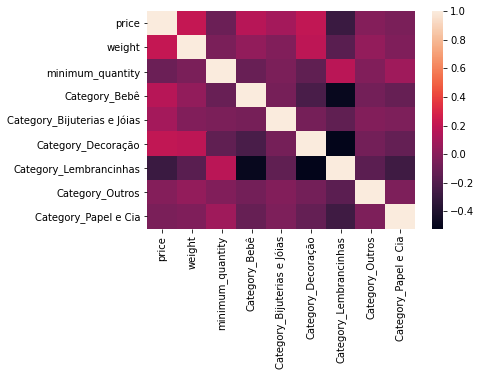

In [26]:
sns.heatmap(df_correct.corr())
plt.show()

In [23]:
df.groupby(['category'])['price', 'weight', 'minimum_quantity'].std0()

,price,weight,minimum_quantity
category,,,
Bebê,289.326192,1432.093863,8.027735
Bijuterias e Jóias,537.850151,368.688881,5.095483
Decoração,272.376557,3057.222855,5.766059
Lembrancinhas,42.647136,277.723665,33.019130
Outros,138.362570,4323.843727,15.488400
Papel e Cia,64.802731,540.600418,135.421863


Como se pode observar há uma baixa correlação entre o **preço**, **peso** e **quantidade minima**. Além disso é interessante notar que eles estão muito idstribuidos sendo dificil correlacionar.

In [10]:
# model = KeyedVectors.load_word2vec_format('cbow_s100.txt')